<a href="https://colab.research.google.com/github/supertime1/Floyer_Analysis/blob/main/Cosinuss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Set up dependency

In [1]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss')

In [2]:
from data_container import config, DataFile
from data_container.api_db_sync import DBSync
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import pickle
import seaborn as sns

2021-03-08 09:32:20 - DEBUG -       dc_config:  45 - DcConfig initialized


#2.Connect to Cosinuss Database

Open redis-server.exe first before running configure_api() 

In [4]:
def configure_api(db_name, username, update_local=False):
    """
    Configure api as the data handler
    """
    try:
        config.init(db_name=db_name)
        api = DBSync(username=username,
                    server = 'https://telecovid.earconnect.de')
    except:
        print('Configure API failed')
        return
    # password: teeshau7aiMonoh9ee
    if update_local:
    # download data from the server
        api.pull_all_dfs(prj_hash_id='M9KH')
    
    df_list_local = api.df_list(prj_hash_id='M9KH')
    print('There are', len(df_list_local), 'files in local database')
    return api


api = configure_api('sonova_analysis', 'sonova.fremont.api')

2021-03-08 09:32:34 - ERROR -       dc_config:  52 - data_container.config.init() can only be called once
2021-03-08 09:32:35 -  INFO -       api_login: 241 - login: sonova.fremont.api @ https://telecovid.earconnect.de
2021-03-08 09:32:36 -  INFO -       api_login: 253 - successful login, it expires 2021-03-08 21:32:36 expiring in 720.0 min


There are 162 files in local database


In [ ]:
def generate_table(date):
    """
    Convert local database into a Pandas dataframe, for ease of data analysis

    params:
    date: select the date that data is generated

    outputs:
    an overview table in the form of pandas dataframe
    """
    table = api.overview_dfs()
    overview_df = pd.DataFrame(table[1:], columns=table[0])
    # change to lower case for the device name
    overview_df['device'] = overview_df['device'].str.lower()
    overview_df.loc[overview_df.device.str.match(r'^polar'), 'device']= 'polar'
    overview_df = overview_df[overview_df.when > date]
    overview_df['when'] = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for 
                           i in list(overview_df['when'])]
    overview_df['duration'] = [datetime.datetime.strptime(i, '%H:%M:%S') for 
                               i in list(overview_df['duration'])]
    overview_df['end'] = [(overview_df.when.loc[i] 
                           - datetime.datetime(1900, 1, 1) 
                           + overview_df.duration.loc[i]) for i in overview_df.index]
    return overview_df

table = generate_table('2020-12-31')
print('There are', len(table), 'test records')
table.head()

There are 63 test records


,person,when,device,df id,duration,samples,cols,end
100,M9KH.BZYG (RaHe),2021-02-08 14:15:09,polar,1C2RATHBVH.C4CDEZ,1900-01-01 00:34:48,2.1 K,heart_rate,2021-02-08 14:49:57
101,M9KH.BZYG (RaHe),2021-02-08 14:15:14,cshell,1C2RATHBVH.38CD8K,1900-01-01 00:34:42,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:56
102,M9KH.BZYG (RaHe),2021-02-08 14:15:23,cshell,1C2RATHBVH.LEMWKL,1900-01-01 00:34:36,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:59
103,M9KH.BZYG (RaHe),2021-02-08 14:15:35,garmin,8QEK89R9B4.NZH5XL,1900-01-01 00:45:27,2.7 K,heart_rate,2021-02-08 15:01:02
104,M9KH.ME9A (LeLo),2021-02-08 15:23:00,polar,1C2RATHBVH.XCMFW1,1900-01-01 00:34:34,2.1 K,heart_rate,2021-02-08 15:57:34


In [ ]:
 def correct_label(table):
    """
    fix the labeling problem of cshell and biometric
    
    params:
    overview table from generate_table function

    outputs:
    updated table with correct cshell and biometric labels

    """
    def get_device_model(df):
        """
        get device
        
        params:
        df - output of api.pull_df
        
        outputs:
        correct device label for df
        """
        # get device
        if df.device:
            device_model = df.device.device_model
        else:
            device_model = df.device_model
        
        if 'polar' in device_model.lower():
            return 'polar'

        elif 'biomeric' in device_model.lower() or 'cshell' in device_model.lower():
            if 'ppg_ir_2' in list(df.cols):
                some_data = df.c.ppg_ir_2.y[600:650]
                if list(some_data):
                    ppg_mean = np.mean(some_data)
                else:
                    return 'na'
            else:
                ppg_mean = 1000
            
            if ppg_mean < 500:
                return 'cshell'
            else:
                return 'biometric'
    
    def get_correct_label(hash_ids, target_device):
        """

        """
        # output list of corrected labels
        corrected_name = []
        # a counter to record how many labels have been corrected after processing
        cnt = 0
        print(f'There are in total {len(hash_ids)} files with {target_device} label')
        for i in range(len(hash_ids)):
            try:
                print(f'api reading {i}th file...')
                df = api.pull_df(list(hash_ids)[i]) 
            # in case reading file failed
            except:
                print(f'api read {i}th file failed!')
                corrected_name.append(table.loc[hash_ids.index[i]].device)
                continue
            # get the new label by api reading the file
            new_label = get_device_model(df)
            corrected_name.append(new_label)
            if new_label != table.loc[hash_ids.index[i]].device:
                print(f'Person {table.loc[hash_ids.index[i]].person} and \
            {target_device} label has been corrected to {new_label}')
                cnt += 1
        print(f'There are in total {cnt} files been corrected')
        return corrected_name

    # get the hash ids of cshell and biometric in original table
    cshell_hash_ids = table[table.device == 'cshell']['df id']
    biometric_hash_ids = table[table.device == 'biometric']['df id']

    # get the row index of cshell and biometric in original table
    original_cshell_index = table[table.device == 'cshell'].index
    original_biometric_index = table[table.device == 'biometric'].index
    
    # update the original table with corrected labels of cshell and biometric
    table.device.loc[original_cshell_index] = get_correct_label(cshell_hash_ids, 
                                                     'cshell')
    table.device.loc[original_biometric_index] = get_correct_label(biometric_hash_ids, 
                                                        'biometric')

    return table

table = correct_label(table)


In [ ]:
table.to_pickle("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/local_db.pkl")

In [ ]:
#load table from local directory
table = pd.read_pickle("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/local_db.pkl")
table.head()

In [ ]:
def find_pairs_row_index(table, floyer_device='cshell'):
    """
    Filter table with paired polar and floyer devices
    """
    paired_table = table[table.device.isin(['polar', floyer_device])]
    
    paired_idx_lst = []
    # find paried sample ids
    for person in list(paired_table['person'].unique()):
        person_paired_table = paired_table[paired_table.person == person]
        polar_idx_lst = person_paired_table[person_paired_table.device == 'polar'].index
        floyer_idx_lst = person_paired_table[person_paired_table.device == floyer_device].index

        # find pairs by checking the overlapping time (2*O(n^2))
        for polar_idx in polar_idx_lst:
            polar_start_time = person_paired_table.when.loc[polar_idx]
            polar_end_time = person_paired_table.end.loc[polar_idx]

            for floyer_idx in floyer_idx_lst:
                floyer_start_time = person_paired_table.when.loc[floyer_idx]
                floyer_end_time = person_paired_table.end.loc[floyer_idx]
                
                if floyer_start_time >= polar_end_time or polar_start_time >= floyer_end_time:
                    continue
                else:
                    paired_idx_lst.append([polar_idx, floyer_idx])
    
    return paired_idx_lst

paired_idx_lst = find_pairs_row_index(table, floyer_device='cshell')
paired_idx_lst

In [ ]:
def generate_paired_samples(paired_idx_lst, table, hr_algo_version):
    """
    Use the index of paired devices (output from find_pairs_row_index) to generate
    a list of PairedSample instances

    params:
    paired_idx_lst: a list containing the row index of paired devices, 
                    It is the output of function find_pairs_row_index.
    table: a Pandas dataframe that stores test infomation, it is the output of the
           correct_label() 

    outputs:
    A list of PairedSample instances
    """
    paired_sample_lst = []
    for polar_idx, floyer_idx in paired_idx_lst:
        polar_hash_id = table['df id'].loc[polar_idx]
        floyer_hash_id = table['df id'].loc[floyer_idx]
        paired_sample_lst.append(PairedSample(polar_hash_id, floyer_hash_id, hr_algo_version))
    return paired_sample_lst

paired_sample_lst = generate_paired_samples(paired_idx_lst, table, 'v0')
# save the paried sample list to save time on next run
with open("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/paired_sample.pkl", "wb") as fp:
    pickle.dump(paired_sample_lst, fp)

2021-03-05 11:24:32 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.C4CDEZ completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 
2021-03-05 11:24:50 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.38CD8K completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 
2021-03-05 11:24:53 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.XCMFW1 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 
2021-03-05 11:25:11 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.G2HHR3 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 
2021-03-05 11:25:14 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.2UJU2G completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices

In [7]:
with open("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/paired_sample.pkl", "rb") as fp:
    paired_sample_lst = pickle.load(fp)

##process the df

In [6]:
class PairedSample:
    
    def __init__(self, polar_hash_id, floyer_hash_id, hr_algo_version):
        self.polar_hash_id = polar_hash_id
        self.floyer_hash_id = floyer_hash_id
        self.header_polar = api.pull_df(polar_hash_id)
        self.header_floyer = api.pull_df(floyer_hash_id)
        self.person_id = self.header_floyer.person.hash_id
        self.hr_algo_version = hr_algo_version
        self.df = pd.DataFrame()
    
    def process(self):
        """
        Generate a pandas table for data analysis
        """
        # read polar data
        polar = DataFile.objects(_hash_id=self.polar_hash_id).first()
        polar_hr_x = polar.c.heart_rate.x
        polar_hr_y = polar.c.heart_rate.y

        # process floyer data with heart rate algorithm
        floyer = api.one3_hr_algo(self.hr_algo_version, self.floyer_hash_id)
        floyer_hr_x = np.asarray(floyer['heart_rate_t'])
        floyer_hr_y = floyer['heart_rate']
        floyer_quality = floyer['quality']

        offset = (self.header_floyer.date_time_start - self.header_polar.date_time_start).total_seconds()

        # get the activity label
        activity_label = ['Unknown'] * len(floyer_hr_x)
        for i in range(len(self.header_floyer.chunks_labelled)):
            i_th_activity_start = self.header_floyer.chunks_labelled[i].time_offset
            i_th_activity_duration = self.header_floyer.chunks_labelled[i].duration
            i_th_activity_end = i_th_activity_start + i_th_activity_duration
            
            activity_label[round(i_th_activity_start):round(i_th_activity_end)] = \
            [self.header_floyer.chunk_labels[i]] * (round(i_th_activity_end) - round(i_th_activity_start))
        
        # if floyer starts later
        if offset > 0:
            polar_hr = polar_hr_y[int(offset):]
            duration = min(len(polar_hr), len(floyer_hr_y))
            
            final_polar_hr = polar_hr[:duration]
            final_floyer_hr = floyer_hr_y[:duration]
            final_floyer_quality = floyer_quality[:duration]
            final_floyer_activity = activity_label[:duration]

        # if polar starts later
        else:
            floyer_hr = floyer_hr_y[-int(offset):]
            floyer_qa = floyer_quality[-int(offset):]
            floyer_activity = activity_label[-int(offset):]
            duration = min(len(floyer_hr), len(polar_hr_y))

            final_polar_hr = polar_hr_y[:duration]
            final_floyer_hr = floyer_hr[:duration]
            final_floyer_quality = floyer_qa[:duration]
            final_floyer_activity = floyer_activity[:duration]

        # add person id
        final_person_id = [self.person_id] * len(final_floyer_hr)

        dic = {'floyer_hr': final_floyer_hr,
               'polar_hr': final_polar_hr,
               'quality': final_floyer_quality,
               'activity': final_floyer_activity,
               'person': final_person_id 
               }
            
        self.df = pd.DataFrame(data=dic, index=None)
        
        return self.df

In [9]:
def generate_stats_table(paired_sample_lst):
    stats_table = pd.DataFrame(index=None)
    for paired_sample in paired_sample_lst:
        stats_table = stats_table.append(paired_sample.process())
    return stats_table

stats_table = generate_stats_table(paired_sample_lst)

In [110]:
def create_mape_table(stats_table, quality_level):
    """
    Create a table with MAPE for each activity
    """
    mape_lst = []
    da_lst = []
    activity_lst = []
    person_lst = []

    for person in np.unique(stats_table['person']):
        for activity in np.unique(stats_table['activity']):
            if activity == 'Unknown': break
            temp_table = stats_table[(stats_table.person == person) & 
                                     (stats_table.activity == activity)].reset_index()
            sum = 0
            count = 0
            for i in range(len(temp_table)):
                if temp_table['quality'][i] < quality_level or temp_table['quality'][i] > 100:
                    continue
                
                sum += abs(temp_table['floyer_hr'][i] -
                           temp_table['polar_hr'][i]) / temp_table['polar_hr'][i] * 100
                count += 1
            mape = round(sum / count, 2)
            da = round(count / len(temp_table), 2) * 100  

            mape_lst.append(mape)
            da_lst.append(da)
            activity_lst.append(activity)
            person_lst.append(person)

    dic = {'mape': mape_lst,
           'da': da_lst,
           'activity': activity_lst,
           'person': person_lst
           }
        
    df = pd.DataFrame(data=dic, index=None)
    return df
    
mape_df = create_mape_table(stats_table, quality_level=35)
mape_df

In [293]:
def plot_mape(mape_df, person_level=False):
    """
    Make MAPE boxplot
    """
    if not person_level:
        fig, ax = plt.subplots(1, 1)
        ax.set_xticks(np.arange(0,100,10), minor=False)
        ax.grid(b=True, which='major', color='w', linewidth=2.0)
        ax.grid(b=True, which='minor', color='w', linewidth=1)

        g = sns.boxplot(x='mape',
                        y='activity',
                        data=mape_df)
        plt.title('Boxplot of MAPE per Activity', fontsize=20)
        plt.yticks(fontsize=20)
        plt.xlabel('MAPE', fontsize=20)
        plt.ylabel('Activity', fontsize=20)

    else:
        g = sns.FacetGrid(mape_df,
                          col='person',
                          col_wrap=1,
                          height=2,
                          aspect=5,
                          hue='activity'
                          )
        g = g.map(plt.bar, 'activity', 'mape')
        axes = g.axes.flatten()
        person_lst = np.unique(mape_df['person'])

        for i in range(len(axes)):
            axes[i].set_title("Person:  " + person_lst[i], fontsize=14)
        g.set_ylabels('MAPE', fontsize=14)
        g.set_xlabels('Activity', fontsize=14)
        plt.xticks(rotation=45, fontsize=14)
        plt.legend(bbox_to_anchor=(1.4, 5))

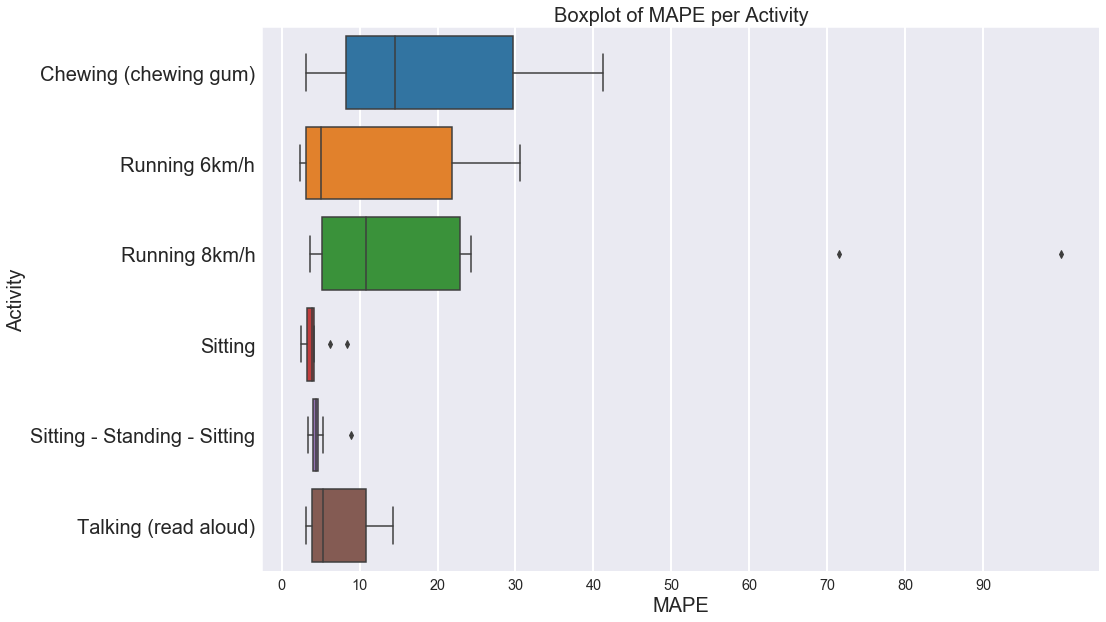

In [294]:
plot_mape(mape_df, person_level=False)

In [291]:
def plot_da(mape_df, person_level=False):
    """
    Make MAPE boxplot
    """
    if not person_level:
        fig, ax = plt.subplots(1, 1)
        ax.set_xticks(np.arange(0,100,10), minor=False)
        ax.grid(b=True, which='major', color='w', linewidth=2.0)
        ax.grid(b=True, which='minor', color='w', linewidth=1)

        g = sns.boxplot(x='da',
                        y='activity',
                        data=mape_df)
        plt.title('Boxplot of DA per Activity', fontsize=20)
        plt.xlabel('Data Availability', fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Activity', fontsize=20)

    else:
        g = sns.FacetGrid(mape_df,
                          col='person',
                          col_wrap=1,
                          height=2,
                          aspect=5,
                          hue='activity'
                          )
        g = g.map(plt.bar, 'activity', 'da')
        axes = g.axes.flatten()
        person_lst = np.unique(mape_df['person'])

        for i in range(len(axes)):
            axes[i].set_title("Person:  " + person_lst[i], fontsize=14)
        g.set_ylabels('DA', fontsize=14)
        g.set_xlabels('Activity', fontsize=14)
        plt.xticks(rotation=45, fontsize=14)
        plt.legend(bbox_to_anchor=(1.4, 5))
        

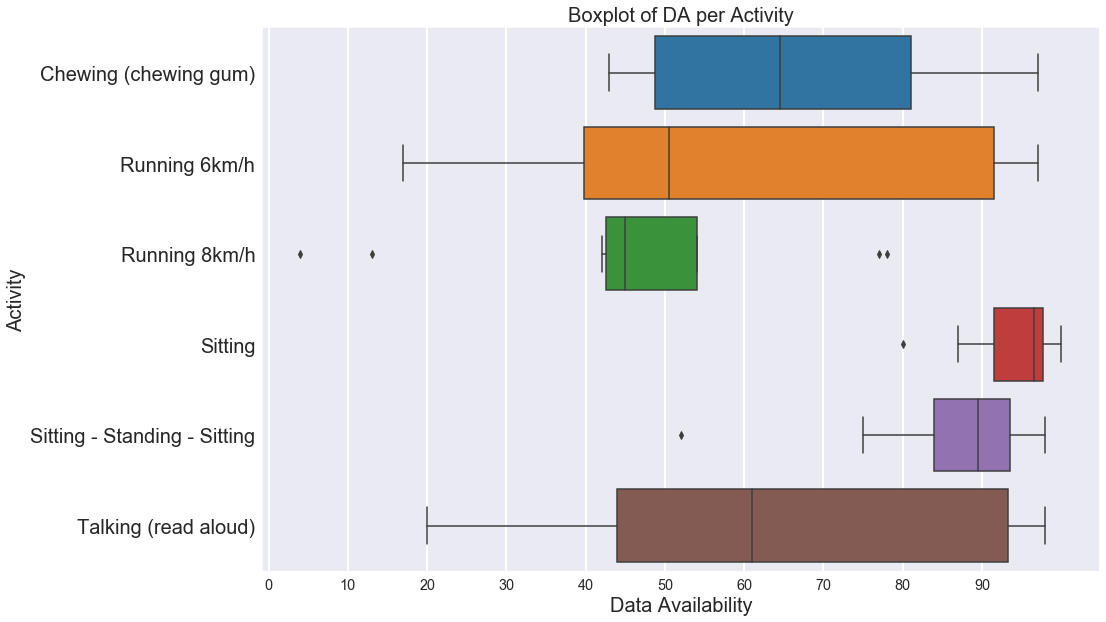

In [292]:
plot_da(mape_df, person_level=False)